# RideWise Customer Analytics
## Notebook 03: Feature Engineering & Churn Modeling (with RFMS)

### Purpose
This notebook trains churn prediction models using the churn-labeled + RFMS dataset created in Notebook 02.

We will:
- Load the processed dataset that includes churn label and RFMS features
- Prepare features (handle NaNs safely, encode categories, scale numeric variables)
- Split into train/test sets (without leakage)
- Train baseline and stronger models
- Evaluate models using churn-relevant metrics
- Interpret results for business action

Key rule: All missing values are handled inside preprocessing pipelines to prevent leakage.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

### Load RFMS dataset

In [2]:
DATA_PATH = "../data/riders_trips_session_churned_rfms.csv"

df = pd.read_csv(DATA_PATH)

print("Dataset shape:", df.shape)
display(df.head(3))

Dataset shape: (10000, 32)


,user_id,signup_date,loyalty_status,age,city,avg_rating_given,churn_prob,referred_by,total_trips,total_spent,avg_fare,total_tip,avg_tip,avg_surge,last_trip_time,first_trip_time,weekend_trip_ratio,peak_hour_trip_ratio,total_sessions,total_time_on_app,avg_time_on_app,total_pages_visited,avg_pages_visited,conversion_rate,last_session_time,first_session_time,weekend_session_ratio,peak_hour_session_ratio,days_since_last_trip,churned,RFMS_weighted_score,RFMS_segment
0,R00000,2025-01-24,Bronze,34.729629,Nairobi,5.0,0.142431,R00001,25,366.05,14.64200,4.03,0.161200,1.096000,2025-04-02 14:46:29+00:00,2024-05-01 07:21:52+00:00,0.160000,0.160000,4.0,368.0,92.000000,12.0,3.000000,0.25,2025-04-27 16:06:46+00:00,2025-04-27 00:49:27+00:00,1.0,0.000000,25,0,2.8,Core Loyal Riders
1,R00001,2024-09-09,Bronze,34.571020,Nairobi,4.7,0.674161,NaN,14,180.53,12.89500,0.76,0.054286,1.071429,2025-04-22 04:35:17+00:00,2024-05-10 18:14:41+00:00,0.285714,0.071429,3.0,524.0,174.666667,8.0,2.666667,0.00,2025-04-27 10:33:25+00:00,2025-04-27 07:10:07+00:00,1.0,1.000000,5,0,1.9,At Risk
2,R00002,2024-09-07,Bronze,47.133960,Lagos,4.2,0.510379,NaN,24,378.99,15.79125,5.21,0.217083,1.191667,2025-04-13 00:08:00+00:00,2024-06-18 17:48:24+00:00,0.125000,0.166667,3.0,573.0,191.000000,9.0,3.000000,0.00,2025-04-27 15:04:35+00:00,2025-04-27 07:32:20+00:00,1.0,0.666667,14,0,3.4,High-Value Surge-Tolerant


### Column and type inventory

In [3]:
dtypes = df.dtypes.astype(str).value_counts()
print("Dtype counts:\n", dtypes)

print("\nColumns by dtype:")
display(pd.DataFrame({"col": df.columns, "dtype": df.dtypes.astype(str)}).sort_values("dtype"))

Dtype counts:
 float64    19
object     10
int64       3
Name: count, dtype: int64

Columns by dtype:


,col,dtype
total_tip,total_tip,float64
total_pages_visited,total_pages_visited,float64
avg_time_on_app,avg_time_on_app,float64
total_time_on_app,total_time_on_app,float64
total_sessions,total_sessions,float64
peak_hour_trip_ratio,peak_hour_trip_ratio,float64
weekend_trip_ratio,weekend_trip_ratio,float64
RFMS_weighted_score,RFMS_weighted_score,float64
avg_surge,avg_surge,float64
avg_tip,avg_tip,float64


### Missing Values Check

In [4]:
na = df.isna().mean().sort_values(ascending=False)
na_top = (na[na > 0] * 100).round(2).to_frame("missing_%")

print(f"Columns with missing values: {na_top.shape[0]}")
display(na_top.head(20))

Columns with missing values: 11


,missing_%
referred_by,69.47
peak_hour_session_ratio,0.71
weekend_session_ratio,0.71
first_session_time,0.71
last_session_time,0.71
conversion_rate,0.71
avg_pages_visited,0.71
total_pages_visited,0.71
avg_time_on_app,0.71
total_time_on_app,0.71


### Drop Irrelevant Columns

In [5]:
df.columns

Index(['user_id', 'signup_date', 'loyalty_status', 'age', 'city', 'avg_rating_given', 'churn_prob', 'referred_by',
       'total_trips', 'total_spent', 'avg_fare', 'total_tip', 'avg_tip', 'avg_surge', 'last_trip_time',
       'first_trip_time', 'weekend_trip_ratio', 'peak_hour_trip_ratio', 'total_sessions', 'total_time_on_app',
       'avg_time_on_app', 'total_pages_visited', 'avg_pages_visited', 'conversion_rate', 'last_session_time',
       'first_session_time', 'weekend_session_ratio', 'peak_hour_session_ratio', 'days_since_last_trip', 'churned',
       'RFMS_weighted_score', 'RFMS_segment'],
      dtype='object')

In [6]:
df.head(5)

,user_id,signup_date,loyalty_status,age,city,avg_rating_given,churn_prob,referred_by,total_trips,total_spent,avg_fare,total_tip,avg_tip,avg_surge,last_trip_time,first_trip_time,weekend_trip_ratio,peak_hour_trip_ratio,total_sessions,total_time_on_app,avg_time_on_app,total_pages_visited,avg_pages_visited,conversion_rate,last_session_time,first_session_time,weekend_session_ratio,peak_hour_session_ratio,days_since_last_trip,churned,RFMS_weighted_score,RFMS_segment
0,R00000,2025-01-24,Bronze,34.729629,Nairobi,5.0,0.142431,R00001,25,366.05,14.642000,4.03,0.161200,1.096000,2025-04-02 14:46:29+00:00,2024-05-01 07:21:52+00:00,0.160000,0.160000,4.0,368.0,92.000000,12.0,3.000000,0.25,2025-04-27 16:06:46+00:00,2025-04-27 00:49:27+00:00,1.0,0.000000,25,0,2.80,Core Loyal Riders
1,R00001,2024-09-09,Bronze,34.571020,Nairobi,4.7,0.674161,NaN,14,180.53,12.895000,0.76,0.054286,1.071429,2025-04-22 04:35:17+00:00,2024-05-10 18:14:41+00:00,0.285714,0.071429,3.0,524.0,174.666667,8.0,2.666667,0.00,2025-04-27 10:33:25+00:00,2025-04-27 07:10:07+00:00,1.0,1.000000,5,0,1.90,At Risk
2,R00002,2024-09-07,Bronze,47.133960,Lagos,4.2,0.510379,NaN,24,378.99,15.791250,5.21,0.217083,1.191667,2025-04-13 00:08:00+00:00,2024-06-18 17:48:24+00:00,0.125000,0.166667,3.0,573.0,191.000000,9.0,3.000000,0.00,2025-04-27 15:04:35+00:00,2025-04-27 07:32:20+00:00,1.0,0.666667,14,0,3.40,High-Value Surge-Tolerant
3,R00003,2025-03-17,Bronze,41.658628,Nairobi,4.9,0.244779,NaN,9,121.47,13.496667,0.87,0.096667,1.155556,2025-02-25 04:22:32+00:00,2024-05-15 05:13:12+00:00,0.333333,0.111111,3.0,226.0,75.333333,5.0,1.666667,0.00,2025-04-27 09:56:39+00:00,2025-04-26 23:28:16+00:00,1.0,0.333333,61,1,1.40,At Risk
4,R00004,2024-08-20,Silver,40.681709,Lagos,3.9,0.269960,R00002,16,268.43,16.776875,9.38,0.586250,1.262500,2025-04-15 05:30:04+00:00,2024-05-23 13:02:45+00:00,0.437500,0.187500,2.0,34.0,17.000000,5.0,2.500000,0.00,2025-04-27 18:28:35+00:00,2025-04-27 06:25:27+00:00,1.0,0.000000,12,0,2.45,Occasional Riders


In [7]:
# df.drop(columns=['user_id', 'churn_prob', 'referred_by', 'days_since_last_trip', 'churned'])

X = df[['total_trips', 'total_spent', 'avg_fare', 'total_tip', 'avg_tip', 'avg_surge', 'total_sessions',
    'total_time_on_app', 'avg_time_on_app', 'total_pages_visited', 'RFMS_segment',  'city', 'loyalty_status', ]]

y = df['churned']

#### Separate numeric vs categorical features

In [8]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", numeric_features)
print("\nCategorical features:", categorical_features)

print("\nCounts:")
print("Numeric:", len(numeric_features))
print("Categorical:", len(categorical_features))

Numeric features: ['total_trips', 'total_spent', 'avg_fare', 'total_tip', 'avg_tip', 'avg_surge', 'total_sessions', 'total_time_on_app', 'avg_time_on_app', 'total_pages_visited']

Categorical features: ['RFMS_segment', 'city', 'loyalty_status']

Counts:
Numeric: 10
Categorical: 3


#### Define preprocessing pipelines

In [9]:
scaler = RobustScaler()

# Numeric preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", scaler)
])

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline defined.")

Preprocessing pipeline defined.


## Preprocessing Design Decisions

Before training any model, we carefully defined how features are preprocessed to ensure:
- No data leakage
- Robustness to outliers
- Stability during retraining
- Compatibility with FastAPI and cloud deployment

This section documents the rationale behind each preprocessing choice.

---

### Feature Typing Summary

The feature matrix consists of:

- **24 numeric features**, including:
  - Usage and engagement metrics (e.g. total trips, sessions, time on app)
  - Monetary value features (e.g. total spend, average fare, tips)
  - Behavioral ratios (e.g. weekend usage, peak-hour usage)
  - Time-derived features (e.g. tenure, session span)
  - RFMS weighted score

- **3 categorical features**:
  - `city`
  - `loyalty_status`
  - `RFMS_segment`

Correctly separating numeric and categorical features is critical because each group requires different preprocessing strategies.

---

### Handling Missing Values

Missing values in this dataset do **not** represent data corruption.  
They typically indicate **lack of activity** (e.g. users with no sessions).

To handle missingness safely and consistently:

- **Numeric features** use:
  - `SimpleImputer(strategy="median")`
  - Median imputation is robust to outliers and preserves distribution shape

- **Categorical features** use:
  - `SimpleImputer(strategy="most_frequent")`
  - Ensures valid categories for encoding and avoids introducing artificial labels

Imputation is performed **inside the modeling pipeline** to prevent data leakage and ensure consistent behavior during inference.

---

### Scaling Numeric Features

Numeric features vary widely in scale and distribution:
- Some are heavily skewed (e.g. total spend, time on app)
- Some contain outliers (expected in user behavior data)

We use:

- **`RobustScaler()`**

**Why RobustScaler?**
- Uses median and interquartile range (IQR)
- Much less sensitive to outliers than StandardScaler
- Preserves relative ordering of users
- Performs well in churn and behavioral modeling contexts

This choice improves model stability and generalization.

---

### Encoding Categorical Features

Categorical features do **not** have a guaranteed ordinal relationship:

- `city` → purely nominal
- `loyalty_status` → appears ordered but does not imply linear numeric effect
- `RFMS_segment` → segment labels, not magnitude

We therefore use:

- **`OneHotEncoder(handle_unknown="ignore")`**

**Why OneHotEncoder?**
- Prevents incorrect ordinal assumptions
- Produces interpretable features
- Safely handles unseen categories during inference
- Ideal for FastAPI-based production systems

---

### Pipeline-Based Preprocessing (Production-Ready)

All preprocessing steps are implemented using:
- `Pipeline`
- `ColumnTransformer`

This ensures:
- No leakage between training and test data
- Identical transformations during training and inference
- Easy serialization and deployment (e.g. via `joblib`)
- Clean integration with FastAPI and cloud services

---

#### Train / Test Split

In [10]:
# 80/20 split, stratified by churn label
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

print("\nChurn rate in full dataset:", y.mean().round(3))
print("Churn rate in train:", y_train.mean().round(3))
print("Churn rate in test:", y_test.mean().round(3))

Train shape: (8000, 13) (8000,)
Test shape: (2000, 13) (2000,)

Churn rate in full dataset: 0.189
Churn rate in train: 0.189
Churn rate in test: 0.188


### Baseline Logistic Regression Pipeline

In [11]:
baseline_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

print("Baseline Logistic Regression pipeline created.")

Baseline Logistic Regression pipeline created.


#### Train the Baseline Model

In [12]:
baseline_model.fit(X_train, y_train)

print("Baseline model trained.")

Baseline model trained.


#### Evaluate Baseline Performance

In [13]:
# Predict probabilities and labels
y_proba = baseline_model.predict_proba(X_test)[:, 1]
y_pred = baseline_model.predict(X_test)

# Metrics
roc_auc = roc_auc_score(y_test, y_proba)

print("ROC-AUC:", round(roc_auc, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


print(confusion_matrix(y_test, y_pred))

ROC-AUC: 0.8642

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.74      0.84      1623
           1       0.44      0.85      0.57       377

    accuracy                           0.76      2000
   macro avg       0.69      0.80      0.71      2000
weighted avg       0.86      0.76      0.79      2000

[[1209  414]
 [  58  319]]


#### Visualize Precision–Recall tradeoff

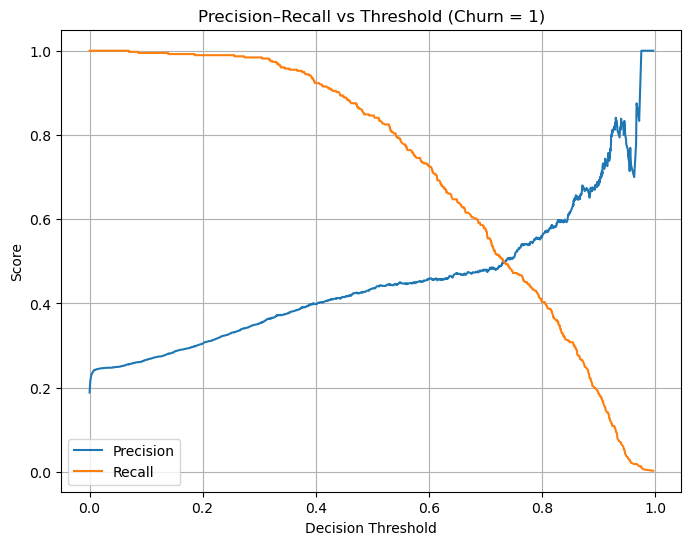

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall vs Threshold (Churn = 1)")
plt.legend()
plt.grid(True)
plt.show()

### Train Random Forest Model

In [15]:
# Random Forest

rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=20,
    min_samples_split=40,
    max_features="sqrt",
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

model_rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("rf", rf)
])

model_rf.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['total_trips', 'total_spent',
                                                   'avg_fare', 'total_tip',
                                                   'avg_tip', 'avg_surge',
                                                   'total_sessions',
                                                   'total_time_on_app',
                                                   'avg_time_on_app',
                                                   'total_pages_visited']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['RFMS_segment', 'city',
                                                   'loyalty_status'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        min_samples_leaf=20,
                                        min_samples_split=40, n_estimators=500,
                                        n_jobs=-1, random_state=42))])

In [16]:
# Predict probabilities and labels
y_proba = model_rf.predict_proba(X_test)[:, 1]
y_pred = model_rf.predict(X_test)

# Metrics
roc_auc = roc_auc_score(y_test, y_proba)

print("ROC-AUC:", round(roc_auc, 4))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

ROC-AUC: 0.8829

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      1623
           1       0.45      0.92      0.60       377

    accuracy                           0.77      2000
   macro avg       0.71      0.83      0.72      2000
weighted avg       0.88      0.77      0.79      2000

[[1196  427]
 [  31  346]]



Confusion Matrix:


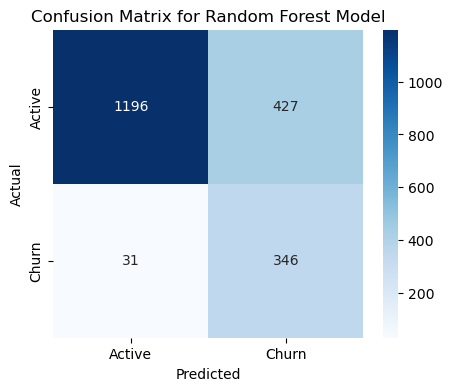

In [17]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Active", "Churn"],
            yticklabels=["Active", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Random Forest Model")
plt.show()

#### Visualize Precision–Recall tradeoff

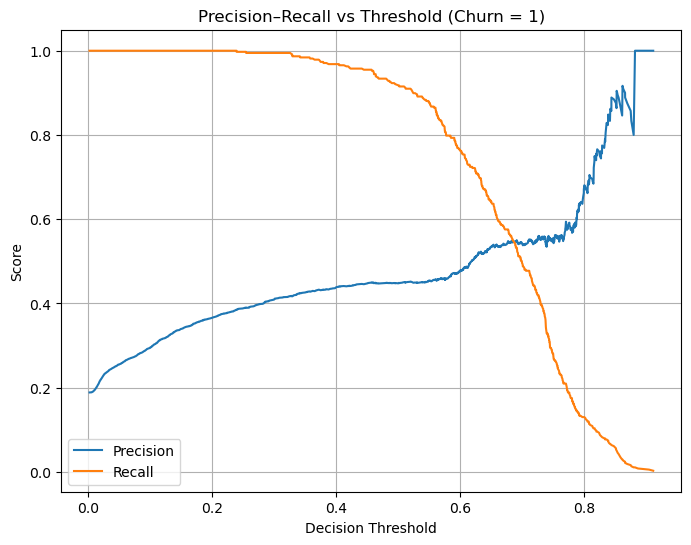

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall vs Threshold (Churn = 1)")
plt.legend()
plt.grid(True)
plt.show()

#### Create a threshold performance table

In [19]:
threshold_grid = np.arange(0.05, 0.95, 0.05)

rows = []

for t in threshold_grid:
    y_pred_t = (y_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    rows.append({
        "threshold": t,
        "precision": tp / (tp + fp) if (tp + fp) > 0 else 0,
        "recall": tp / (tp + fn) if (tp + fn) > 0 else 0,
        "false_positives": fp,
        "false_negatives": fn
    })

threshold_df = pd.DataFrame(rows)
display(threshold_df)

,threshold,precision,recall,false_positives,false_negatives
0,0.05,0.255074,1.000000,1101,0
1,0.10,0.294531,1.000000,903,0
2,0.15,0.339334,1.000000,734,0
3,0.20,0.365664,1.000000,654,0
4,0.25,0.388430,0.997347,592,1
5,0.30,0.408942,0.994695,542,2
6,0.35,0.425947,0.984085,500,6
7,0.40,0.438175,0.968170,468,12
8,0.45,0.447205,0.954907,445,17
9,0.50,0.447607,0.917772,427,31


#### Choose and lock a business threshold

In [20]:
BUSINESS_THRESHOLD = 0.35

y_pred_business = (y_proba >= BUSINESS_THRESHOLD).astype(int)

print("Chosen threshold:", BUSINESS_THRESHOLD)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_business))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_business))

Chosen threshold: 0.35

Confusion Matrix:
[[1123  500]
 [   6  371]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.69      0.82      1623
           1       0.43      0.98      0.59       377

    accuracy                           0.75      2000
   macro avg       0.71      0.84      0.71      2000
weighted avg       0.89      0.75      0.77      2000



#### Visualize confusion matrix

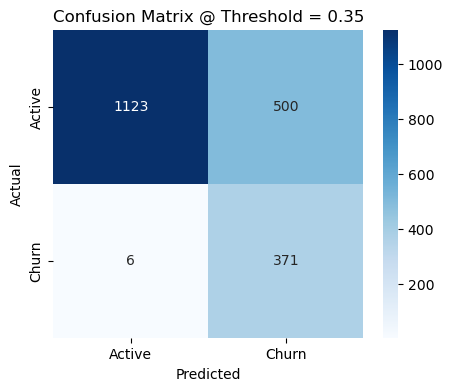

In [21]:
cm = confusion_matrix(y_test, y_pred_business)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Active", "Churn"],
            yticklabels=["Active", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix @ Threshold = {BUSINESS_THRESHOLD}")
plt.show()

### Feature Importance

In [22]:
# # Define model directory
# MODEL_DIR = "../web_app_for_churn_prediction/model"
# os.makedirs(MODEL_DIR, exist_ok=True)

# # File paths
# MODEL_PATH = os.path.join(MODEL_DIR, "churn_model_pipeline.joblib")
# METADATA_PATH = os.path.join(MODEL_DIR, "churn_model_metadata.joblib")

# # Save the trained pipeline
# joblib.dump(model_rf, MODEL_PATH)

# # Save metadata needed for inference
# joblib.dump(
#     {
#         "business_threshold": BUSINESS_THRESHOLD,
#         "feature_columns": X.columns.tolist()
#     },
#     METADATA_PATH
# )

# print("✅ Model saved to:", MODEL_PATH)
# print("✅ Metadata saved to:", METADATA_PATH)

✅ Model saved to: ../web_app_for_churn_prediction/model\churn_model_pipeline.joblib
✅ Metadata saved to: ../web_app_for_churn_prediction/model\churn_model_metadata.joblib
